## Import packages

In [2]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.stats as sc
import metpy as mtp
import math
from scipy import integrate
import pandas as pd

from matplotlib.pyplot import cm
import datetime as dt

import cartopy.crs as ccrs
from numpy.random import default_rng

import sys  
sys.path.insert(0, '../')
import ERA5_functions as era_fncts

%load_ext autoreload
%autoreload 2

### Constants

In [3]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

### Dims

In [4]:
lats = np.linspace(90, -90, 361)
lons = np.linspace(0, 359.5, 720)
levels = [1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 350,
            400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

### Load instantaneous AHT calcs

In [62]:
aht_ds = xr.open_dataset('../aht_time_series/era5_aht_time_series.nc')

aaron_aht_ds = xr.open_dataset('../aht_time_series/aaron_aht_data_through_2018_with_time.nc')

### Load CERES data

In [30]:
ceres_ds = xr.open_dataset('../CERES_data.nc')
ceres_ds = ceres_ds.rename({'toa_sw_all_mon':'toa_sw', 'toa_lw_all_mon':'toa_lw',
                 'toa_net_all_mon':'toa_net'})
ceres_lat = ceres_ds.lat
ceres_lon = ceres_ds.lon
ceres_time = ceres_ds.time
ceres_geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(ceres_lat))) * a / g

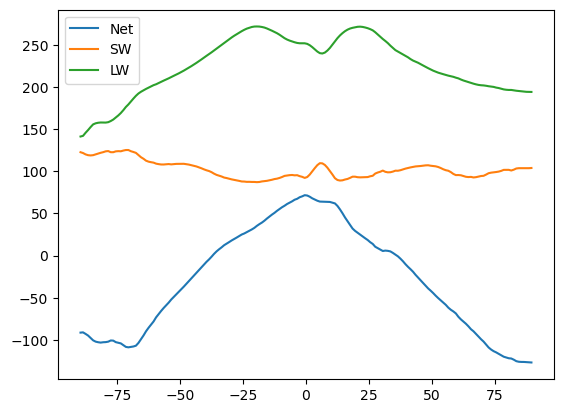

In [18]:
zonal_time_means = ceres_ds.mean(['time', 'lon'])

plt.plot(ceres_lat, zonal_time_means.toa_net, label='Net')
plt.plot(ceres_lat, zonal_time_means.toa_sw, label='SW')
plt.plot(ceres_lat, zonal_time_means.toa_lw, label='LW')

plt.legend(loc=0)
plt.show()

In [45]:
def calc_ceres_aht(toa_field):
    
    toa_mean= np.nansum(toa_field*np.cos(ceres_lat*np.pi/180))/np.nansum(np.cos(ceres_lat*np.pi/180))
    toa_new = toa_field - toa_mean

    aht_integ = integrate.cumtrapz(toa_new, x=np.sin(ceres_lat*np.pi/180), initial=0)
    partial_aht = 2*np.pi*a**2*aht_integ
    
    return partial_aht

In [63]:
aaron_aht_change = aaron_aht_ds.sel(time=slice('2014-01-01', '2018-12-31')).mean(['time']) - aaron_aht_ds.sel(time=slice('2001-01-01', '2005-12-31')).mean(['time'])

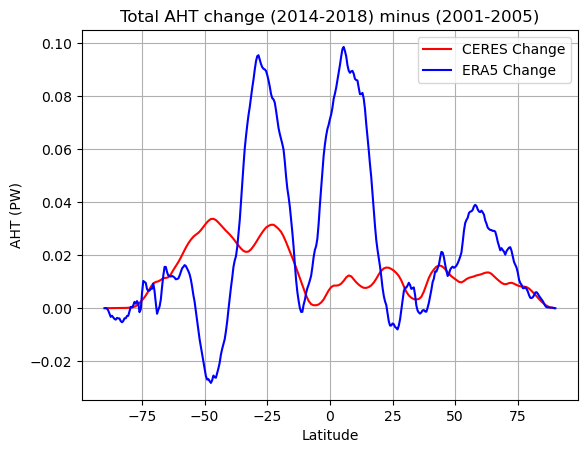

In [68]:
toa_all_time = zonal_time_means.toa_net
partial_aht_all_time = calc_ceres_aht(toa_all_time)

ceres_by_year = ceres_ds.groupby('time.year').mean(['time', 'lon'])

toa_start_time = ceres_by_year.sel(year=[2001, 2002, 2003, 2004, 2005]).mean(['year'])
#toa_end_time = ceres_by_year.sel(year=[2017, 2018, 2019, 2020, 2021]).mean(['year'])
toa_end_time = ceres_by_year.sel(year=[2014, 2015, 2016, 2017, 2018]).mean(['year'])

partial_aht_start_time = calc_ceres_aht(toa_start_time.toa_net)
partial_aht_end_time = calc_ceres_aht(toa_end_time.toa_net)

#plt.plot(ceres_lat, partial_aht_all_time, label='Full')
#plt.plot(ceres_lat, partial_aht_start_time, label='Start')
#plt.plot(ceres_lat, partial_aht_end_time, label='End')

#plt.plot(ceres_lat, partial_aht_start_time - partial_aht_all_time, label='Start')
#plt.plot(ceres_lat, partial_aht_end_time - partial_aht_all_time, label='End')

plt.plot(ceres_lat, (partial_aht_end_time - partial_aht_start_time)/1e15,
         color='r', label='CERES Change')

plt.plot(lats, aaron_aht_change.total_aht / 1e15,
         color='b', label='ERA5 Change')
plt.legend(loc=0)
plt.grid()
plt.xlabel('Latitude')
plt.ylabel('AHT (PW)')
plt.title('Total AHT change (2014-2018) minus (2001-2005)')

#plt.savefig('../figures/5_24_22_meeting/total_aht_changes_from_ceres_and_era5')
plt.show()

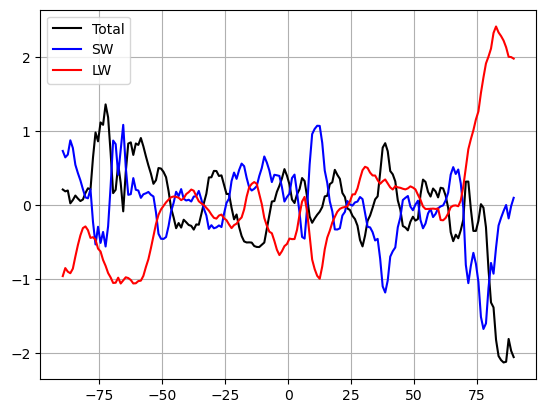

In [76]:
toa_diff = (toa_end_time - toa_start_time)
toa_diff = toa_diff - toa_diff.mean(['lat'])

plt.plot(ceres_lat, toa_diff.toa_net, color='k', label='Total')
plt.plot(ceres_lat, toa_diff.toa_sw, color='b', label='SW')
plt.plot(ceres_lat, toa_diff.toa_lw, color='r', label='LW')

plt.legend(loc=0)
plt.grid()
plt.show()

In [24]:
toa_net_slopes = np.zeros(len(ceres_lat))
toa_sw_slopes = np.zeros(len(ceres_lat))
toa_lw_slopes = np.zeros(len(ceres_lat))

zonal_means = ceres_ds.mean(['lon'])

for idx, lat in enumerate(ceres_lat.values):
    toa_net_regress = sc.linregress(zonal_means.toa_net.sel(lat=lat).values, range(264))
    toa_net_slopes[idx] = toa_net_regress.slope
    
    toa_sw_regress = sc.linregress(zonal_means.toa_sw.sel(lat=lat).values, range(264))
    toa_sw_slopes[idx] = toa_sw_regress.slope
    
    toa_lw_regress = sc.linregress(zonal_means.toa_lw.sel(lat=lat).values, range(264))
    toa_lw_slopes[idx] = toa_lw_regress.slope

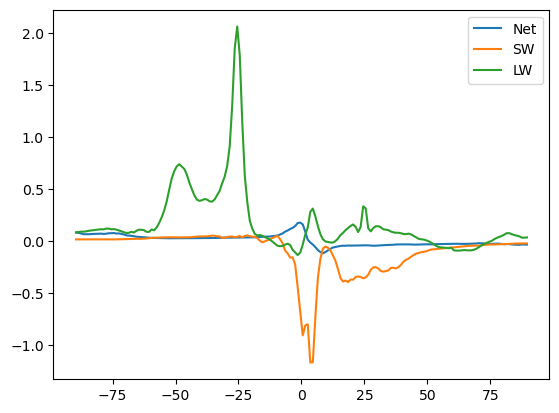

In [25]:
plt.plot(ceres_lat, toa_net_slopes, label='Net')
plt.plot(ceres_lat, toa_sw_slopes, label='SW')
plt.plot(ceres_lat, toa_lw_slopes, label='LW')

plt.legend(loc=0)
plt.show()